In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [ ]:
from langchain_community.document_loaders import WebBaseLoader

docs = [
  'https://en.wikipedia.org/wiki/Attention_Is_All_You_Need',
  'https://en.wikipedia.org/wiki/Seq2seq'
]

docs = [WebBaseLoader(doc).load() for doc in docs]
docs


USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Attention_Is_All_You_Need', 'title': 'Attention Is All You Need - Wikipedia', 'language': 'en'}, page_content='\n\n\n\nAttention Is All You Need - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload fileSpecial pages\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDonate\n\nCreate account\n\nLog in\n\n\n\n\n\n\n\n\nPersonal tools\n\n\n\n\n\nDonate Create account Log in\n\n\n\n\n\n\t\tPages for logged out editors learn more\n\n\n\nContributionsTalk\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nConte

In [9]:
docs_list = [item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Attention_Is_All_You_Need', 'title': 'Attention Is All You Need - Wikipedia', 'language': 'en'}, page_content='\n\n\n\nAttention Is All You Need - Wikipedia\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nJump to content\n\n\n\n\n\n\n\nMain menu\n\n\n\n\n\nMain menu\nmove to sidebar\nhide\n\n\n\n\t\tNavigation\n\t\n\n\nMain pageContentsCurrent eventsRandom articleAbout WikipediaContact us\n\n\n\n\n\n\t\tContribute\n\t\n\n\nHelpLearn to editCommunity portalRecent changesUpload fileSpecial pages\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\nSearch\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAppearance\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDonate\n\nCreate account\n\nLog in\n\n\n\n\n\n\n\n\nPersonal tools\n\n\n\n\n\nDonate Create account Log in\n\n\n\n\n\n\t\tPages for logged out editors learn more\n\n\n\nContributionsTalk\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nConten

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

docs_split = text_splitter.split_documents(docs_list)


In [16]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

vectorstore = FAISS.from_documents(
  documents=docs_split,
  embedding=embeddings
)

In [22]:
retriever = vectorstore.as_retriever(
  search_type="similarity",
  search_kwargs={"k": 2}
)

In [23]:
retriever.invoke("what is seq2seq?")

[Document(id='c22f2d5a-b674-4aff-9c3c-93e4ce310c08', metadata={'source': 'https://en.wikipedia.org/wiki/Seq2seq', 'title': 'Seq2seq - Wikipedia', 'language': 'en'}, page_content='Attention for seq2seq[edit]'),
 Document(id='d9eea084-2075-41c3-9f5e-5b89efafc603', metadata={'source': 'https://en.wikipedia.org/wiki/Seq2seq', 'title': 'Seq2seq - Wikipedia', 'language': 'en'}, page_content='The seq2seq method developed in the early 2010s uses two neural networks:  an encoder network converts an input sentence into numerical vectors, and a decoder network converts those vectors to sentences in the target language.  The Attention mechanism was grafted onto this structure in 2014 and shown below. Later it was refined into the encoder-decoder Transformer architecture of 2017.')]

In [24]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retriever",
    description="Useful for retrieving information from the knowledge base."
)

tools = [retriever_tool]

In [26]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [29]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm.invoke("Hey there")

AIMessage(content="How's it going? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 12, 'total_tokens': 33, 'completion_time': 0.044791566, 'prompt_time': 0.002184924, 'queue_time': 0.049280266, 'total_time': 0.04697649}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run-24819ade-16c7-4045-aa4a-c2a32768359b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 21, 'total_tokens': 33})

In [30]:
def agent(state):
  print("---CALL AGENT---")
  llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
  llm = llm.bind_tools(tools)

  response = llm.invoke(state['messages'])
  return {'messages': [response]}

In [31]:
from typing import Literal

from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [ ]:
def grade_document(state) -> Literal['rewrite','generate']:
    print("---CHECK RELEVANCE ---")

    class Grade(BaseModel):
        binary_score: str = Field("description='Relevance score 'yes' or 'no'")

    model = ChatGroq(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            temperature=0.0
        )
    
    model = model.with_structured_output(Grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )


    chain = prompt | model

    messages = state['messages']
    last_message = messages[-1]

    question = messages[0].content
    context = last_message.content

    score_result = chain.invoke({
        "context": context,
        "question": question
    })

    score = score_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"
  
    

In [33]:
def generate(state):

  print("---GENERATE ANSWER---")

  messages = state['messages']
  last_message = messages[-1]

  question = messages[0].content
  context = last_message.content

  prompt = hub.pull("rlm/rag-prompt")

  llm = ChatGroq(
      model="meta-llama/llama-4-scout-17b-16e-instruct",
      temperature=0.0
  )

  llm = llm.bind_tools(tools)

  rag_chain = prompt | llm | StrOutputParser()

  response = rag_chain.invoke({
      "context": context,
      "question": question
  })

  return {'messages': [response]}

In [34]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="llama-3.1-8b-instant")
    response = model.invoke(msg)
    return {"messages": [response]}

In [42]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

graph = StateGraph(AgentState)
retriever = ToolNode([retriever_tool])

graph.add_node('agent', agent)
graph.add_node('retriever', retriever)
graph.add_node('generate', generate)
graph.add_node('rewrite', rewrite)

graph.add_edge(START, 'agent')
graph.add_conditional_edges(
    'agent', 

    tools_condition,
    {
      "tools":"retriever",
      END:END,
    },
)


graph.add_conditional_edges(
    'retriever',
    grade_document
)

graph.add_edge("generate", END)
graph.add_edge("rewrite", "agent")

graph = graph.compile()

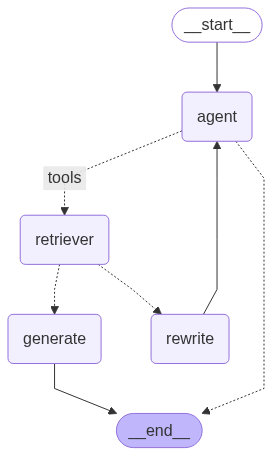

In [43]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [54]:
graph.invoke({"messages":"How does seq2seq work and why do we use it and is attention needed?"})

---CALL AGENT---


{'messages': [HumanMessage(content='How does seq2seq work and why do we use it and is attention needed?', additional_kwargs={}, response_metadata={}, id='8e5c20bf-e923-4713-b89d-d29347514581'),
  AIMessage(content='Seq2seq, short for sequence-to-sequence, is a type of neural network architecture used primarily in natural language processing (NLP) tasks such as machine translation, text summarization, and chatbots. It works by taking a sequence of elements (like words or characters) as input and generating another sequence as output.\n\nThe seq2seq model typically consists of two main components: an encoder and a decoder. The encoder reads the input sequence and converts it into a fixed-length vector representation. The decoder then generates the output sequence, one element at a time, based on this vector representation.\n\nThe process can be broken down into the following steps:\n\n1. **Encoding**: The encoder processes the input sequence, which could be a sentence in a source languag